# Implement integrated gradients

This should be integrated in evaluate_single_model.py and in the Evaluator class (maybe in load_predict_data?)

TODO: this should also be run on final ensemble models. For this, need to first create a final ensemble model

In [89]:
import meld_graph
import meld_graph.models
import meld_graph.experiment
import meld_graph.dataset
import meld_graph.data_preprocessing
import meld_graph.evaluation
import torch_geometric.data
import matplotlib.pyplot as plt

from meld_classifier.paths import NVERT
from meld_graph.dataset import GraphDataset
from meld_classifier.meld_cohort import MeldCohort

from meld_graph.evaluation import Evaluator
import numpy as np
import matplotlib_surface_plotting as msp
import torch

import captum
from captum.attr import IntegratedGradients
from torch import nn

class Prediction(nn.Module):
    """
    Adds layer to model to output the sum of all predicted lesional vertices for integrated gradients
    TODO calculate threshold inside this class
    """
    def __init__(self, model, threshold=0.03):
        super().__init__()
        self.model = model
        self.threshold=threshold
        
    def forward(self, input):
        prediction = torch.exp(self.model(input)['log_softmax'])
        prediction = torch.mean(prediction[prediction[:,1] >= threshold], axis=0)
        # return shape is (1,2)
        return prediction[None,:]
       

In [2]:
model_name = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-03-06_WELH_classification_distance/s_0/fold_00'
split = 'val'

In [3]:
# from evaluate_single_model.sh
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')
exp = meld_graph.experiment.Experiment.from_folder(model_name)

subjects = exp.data_parameters[f'{split}_ids']

features= exp.data_parameters['features']
exp.data_parameters['augment_data']={}

dataset = GraphDataset(subjects, cohort, exp.data_parameters, mode='test')

eva = Evaluator(experiment = exp,
                checkpoint_path = model_name,
                save_dir = model_name,
                make_images = False,
                dataset=dataset,
                cohort=cohort,
                subject_ids = subjects,
                mode = 'test')

Initialised Experiment 23-03-06_WELH_classification_distance/s_0
Loading and preprocessing test data
Z-scoring data for MELD_H3_3T_C_0024
Z-scoring data for MELD_H17_3T_FCD_0075
Z-scoring data for MELD_H3_3T_C_0060
Z-scoring data for MELD_H15_3T_FCD_0006
Z-scoring data for MELD_H4_3T_C_0017
Z-scoring data for MELD_H9_3T_FCD_0009
Z-scoring data for MELD_H23_15T_FCD_0037
Z-scoring data for MELD_H3_3T_C_0005
Z-scoring data for MELD_H18_3T_FCD_0004
Z-scoring data for MELD_H14_3T_FCD_0002
Z-scoring data for MELD_H15_3T_C_0026
Z-scoring data for MELD_H4_15T_FCD_0006
Z-scoring data for MELD_H4_3T_FCD_0021
Z-scoring data for MELD_H14_3T_FCD_0010
Z-scoring data for MELD_H14_3T_C_0023
Z-scoring data for MELD_H24_3T_FCD_0014
Z-scoring data for MELD_H15_3T_C_0023
Z-scoring data for MELD_H3_3T_C_0063
Z-scoring data for MELD_H2_15T_C_0005
Z-scoring data for MELD_H12_3T_C_0030
Z-scoring data for MELD_H2_3T_FCD_0015
Z-scoring data for MELD_H23_15T_FCD_0016
Z-scoring data for MELD_H3_3T_FCD_0001
Z-scor

In [4]:
# from Evaluator.load_predict_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# predict on data
#TODO: enable batch_size > 1
data_loader = torch_geometric.loader.DataLoader(
    dataset,
    shuffle=False,
    batch_size=1, 
)

# put model on device
exp.model.to(device)

In [5]:
# TODO determine threshold per hemisphere using distances
threshold = 0.03

In [70]:
# model that outputs only prediction (needed for IG)   
model = Prediction(exp.model)
integrated_gradients = IntegratedGradients(model)

In [90]:
subjects

['MELD_H3_3T_C_0024',
 'MELD_H17_3T_FCD_0075',
 'MELD_H3_3T_C_0060',
 'MELD_H15_3T_FCD_0006',
 'MELD_H4_3T_C_0017',
 'MELD_H9_3T_FCD_0009',
 'MELD_H23_15T_FCD_0037',
 'MELD_H3_3T_C_0005',
 'MELD_H18_3T_FCD_0004',
 'MELD_H14_3T_FCD_0002',
 'MELD_H15_3T_C_0026',
 'MELD_H4_15T_FCD_0006',
 'MELD_H4_3T_FCD_0021',
 'MELD_H14_3T_FCD_0010',
 'MELD_H14_3T_C_0023',
 'MELD_H24_3T_FCD_0014',
 'MELD_H15_3T_C_0023',
 'MELD_H3_3T_C_0063',
 'MELD_H2_15T_C_0005',
 'MELD_H12_3T_C_0030',
 'MELD_H2_3T_FCD_0015',
 'MELD_H23_15T_FCD_0016',
 'MELD_H3_3T_FCD_0001',
 'MELD_H4_3T_C_0011',
 'MELD_H11_3T_FCD_0033',
 'MELD_H15_3T_C_0002',
 'MELD_H4_15T_C_0009',
 'MELD_H4_3T_FCD_0032',
 'MELD_H24_3T_FCD_0021',
 'MELD_H4_3T_C_0005',
 'MELD_H11_3T_FCD_0024',
 'MELD_H4_15T_C_0013',
 'MELD_H12_3T_C_0013',
 'MELD_H4_15T_FCD_0010',
 'MELD_H15_3T_FCD_0001',
 'MELD_H2_15T_C_0004',
 'MELD_H10_3T_FCD_0011',
 'MELD_H17_3T_FCD_0082',
 'MELD_H3_3T_C_0092',
 'MELD_H17_3T_FCD_0033',
 'MELD_H17_15T_FCD_0106',
 'MELD_H21_3T_FCD_002

In [91]:
for i, data in enumerate(data_loader):
    subject_index =  i//2
    hemi = ['lh','rh'][i%2]
    if hemi=='lh':
        prediction_array = []
        distance_map_array = []
        labels_array = []
        features_array = []
        geodesic_array = []
    subj_id = subjects[subject_index]
    data = data.to(device)
    estimates = exp.model(data.x)
    prediction = torch.exp(estimates['log_softmax'])[:,1]
    # are there lesional predictions?
    if (prediction > threshold).max():
        # if yes, calculate saliency
        print(f'calculating saliency for {subj_id} {hemi}')
        saliency = integrated_gradients.attribute(data.x, target=1, n_steps=25, 
                                                 method='gausslegendre', internal_batch_size=100).cpu().numpy()
       
    if i == 6:
        break

calculating saliency for MELD_H17_3T_FCD_0075 lh
calculating saliency for MELD_H15_3T_FCD_0006 lh


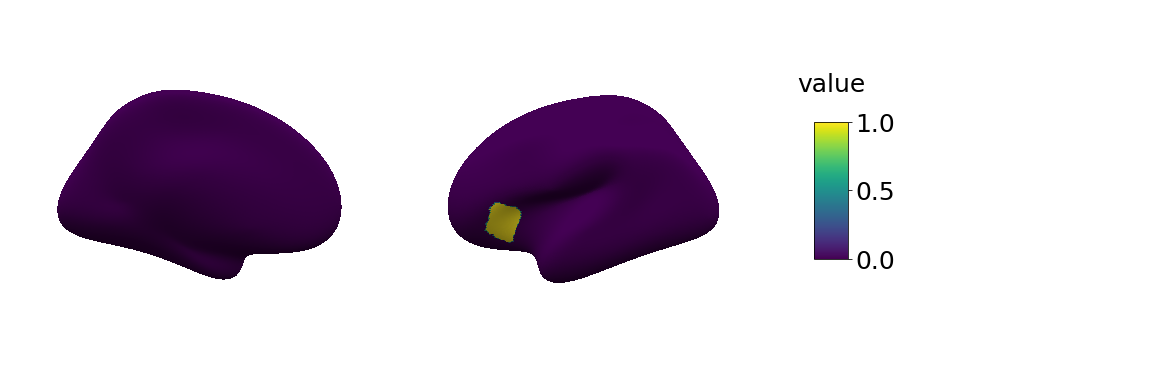

In [92]:
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],data.y.cpu().numpy())

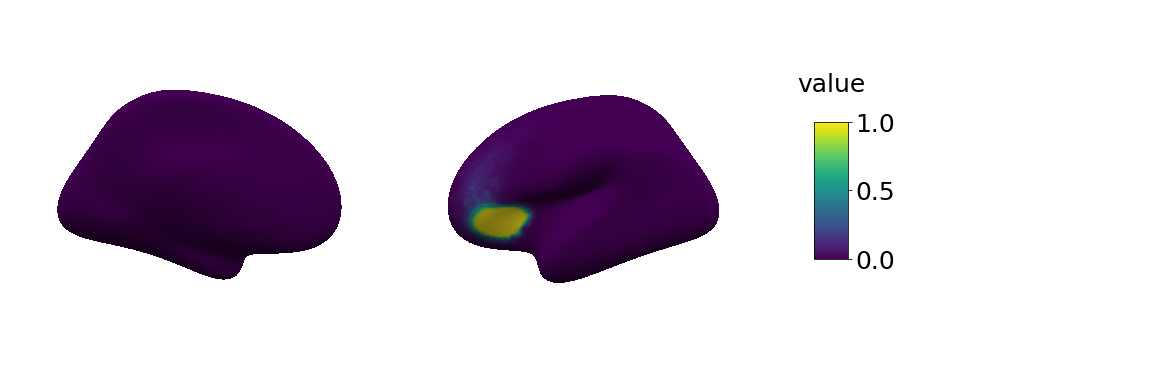

In [93]:
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],prediction.cpu().detach().numpy())

/tmp/ipykernel_1380304/4021922393.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

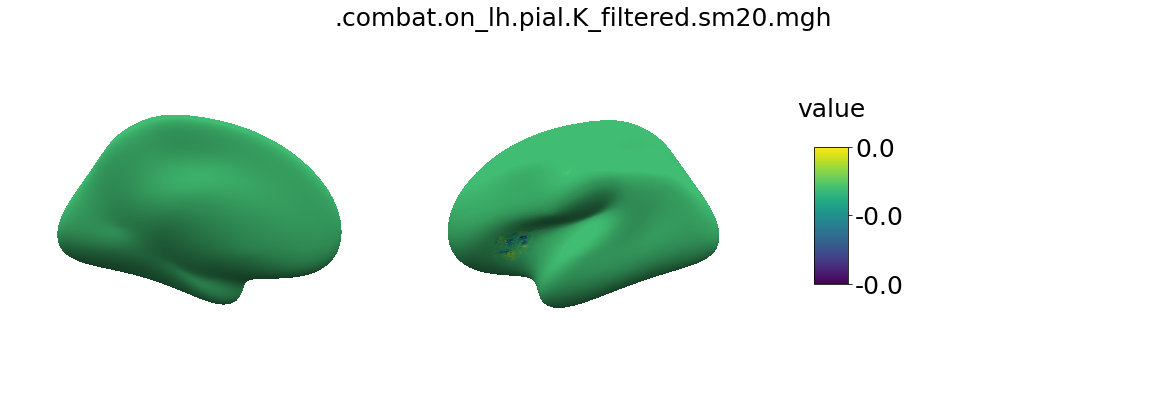

<Figure size 432x288 with 0 Axes>

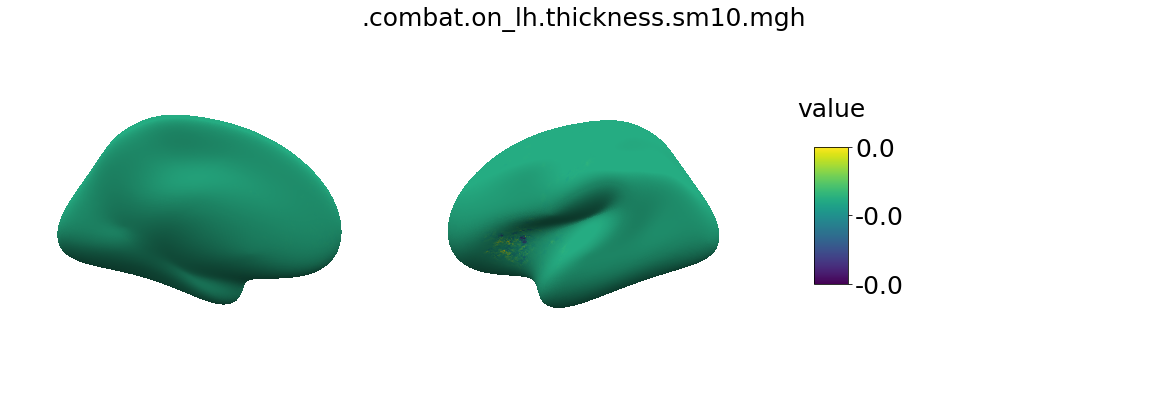

<Figure size 432x288 with 0 Axes>

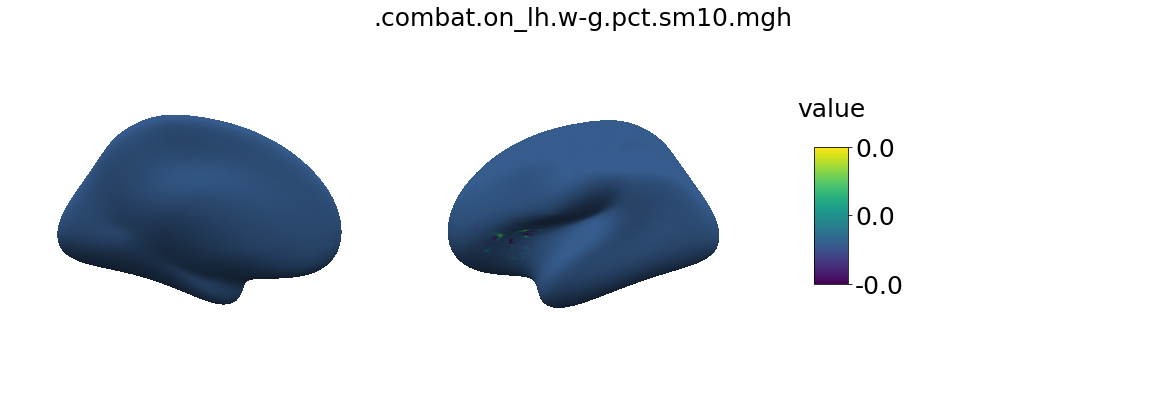

<Figure size 432x288 with 0 Axes>

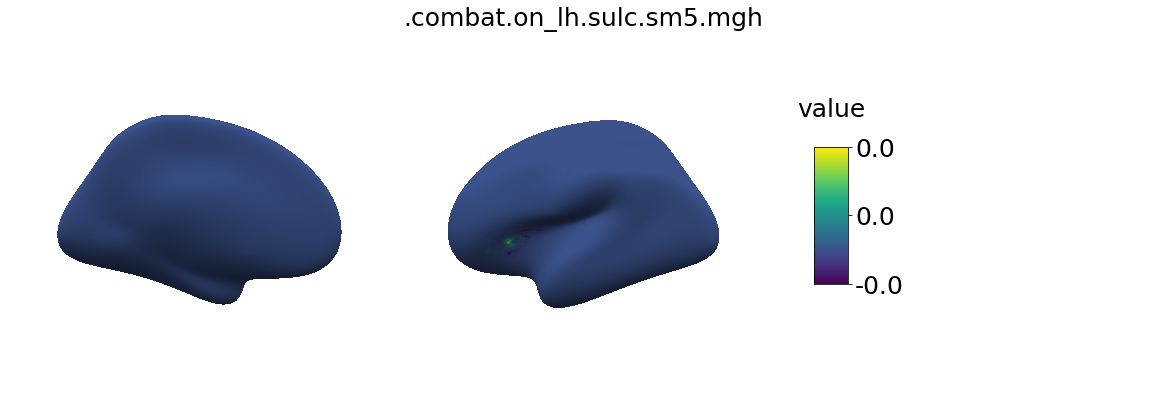

<Figure size 432x288 with 0 Axes>

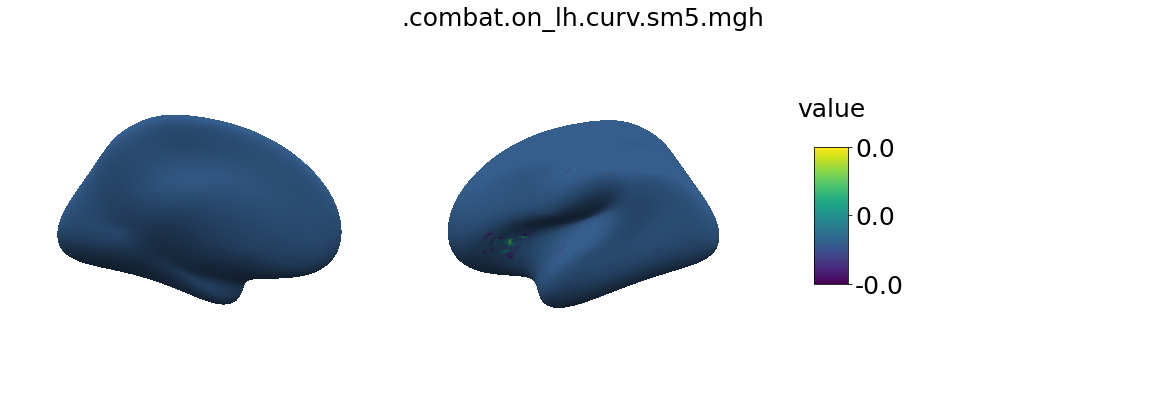

<Figure size 432x288 with 0 Axes>

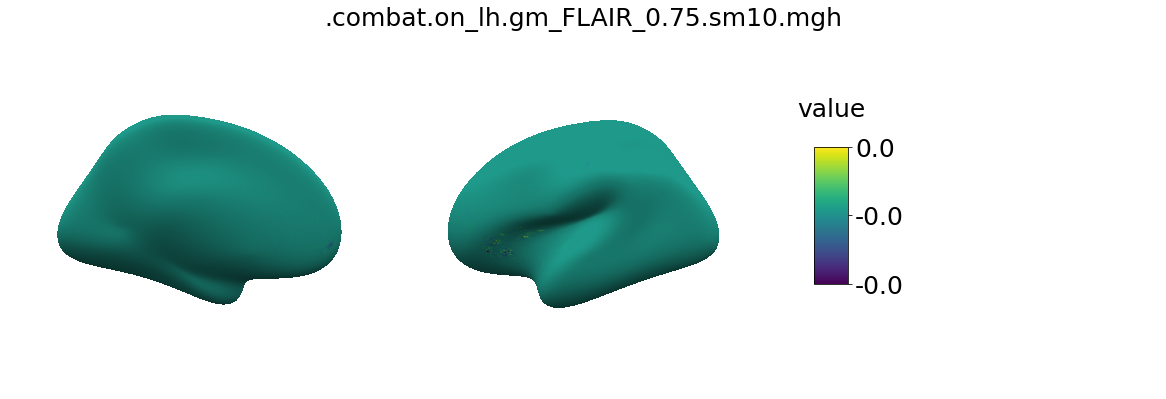

<Figure size 432x288 with 0 Axes>

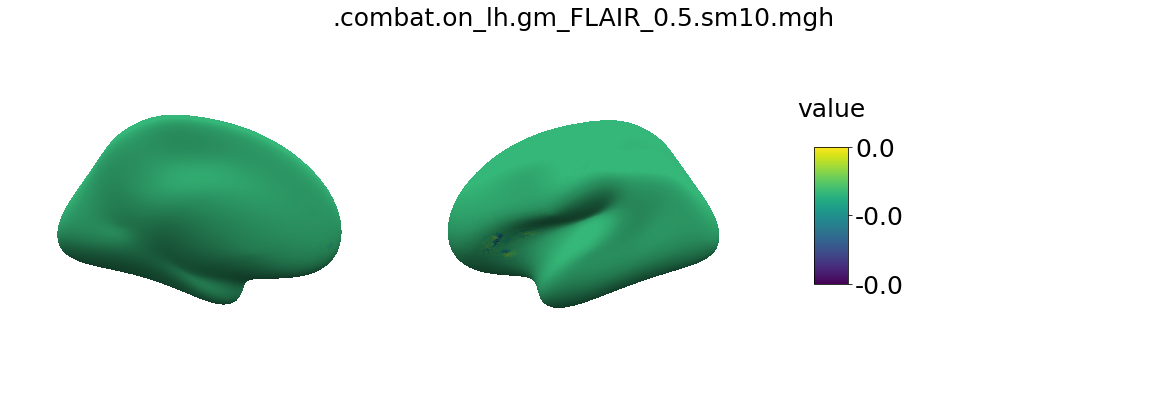

<Figure size 432x288 with 0 Axes>

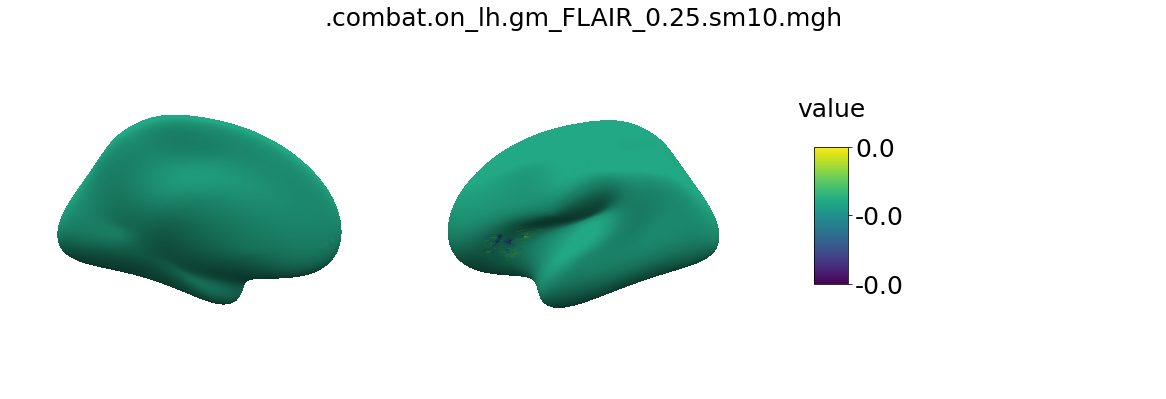

<Figure size 432x288 with 0 Axes>

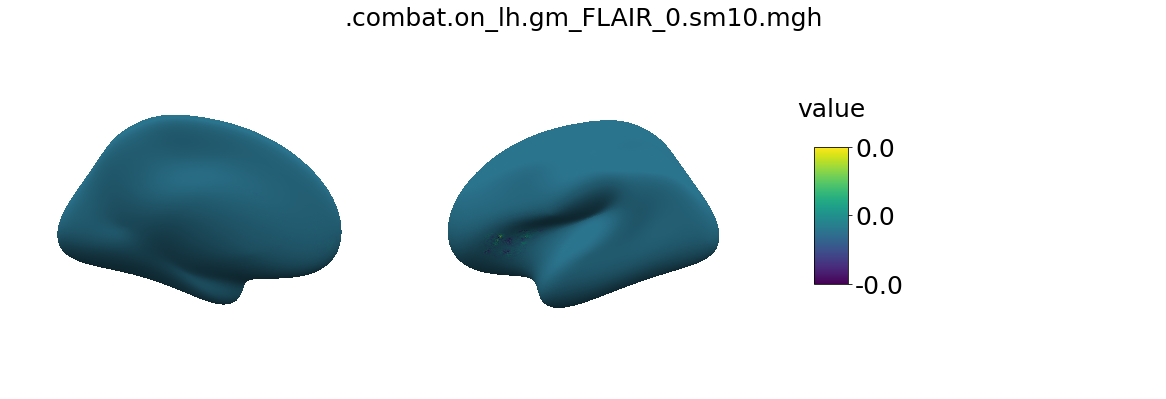

<Figure size 432x288 with 0 Axes>

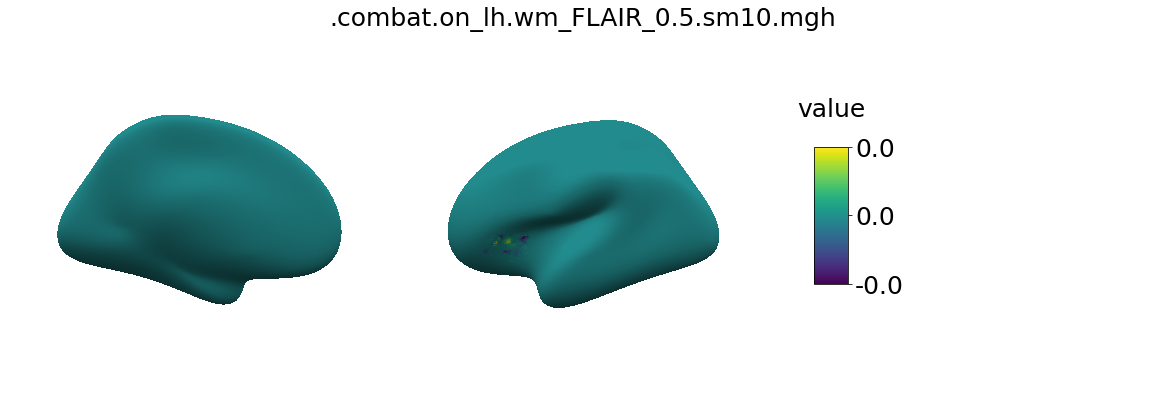

<Figure size 432x288 with 0 Axes>

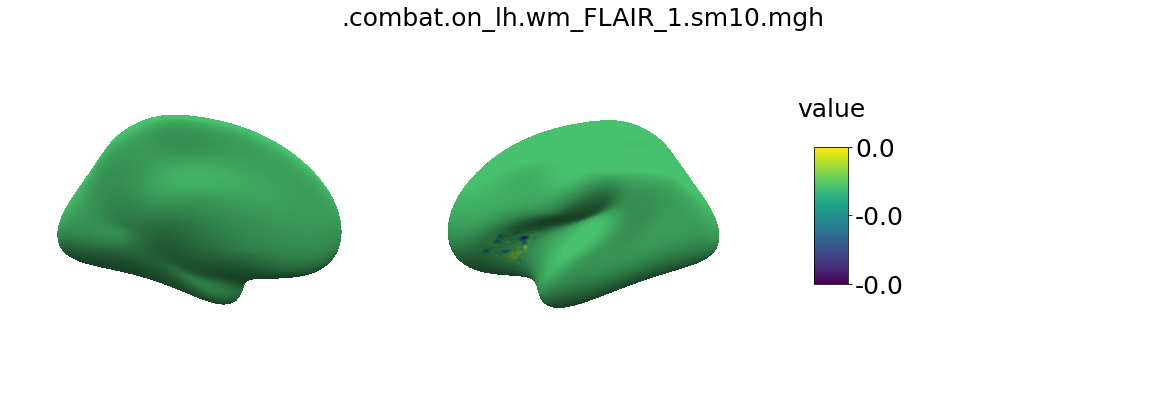

<Figure size 432x288 with 0 Axes>

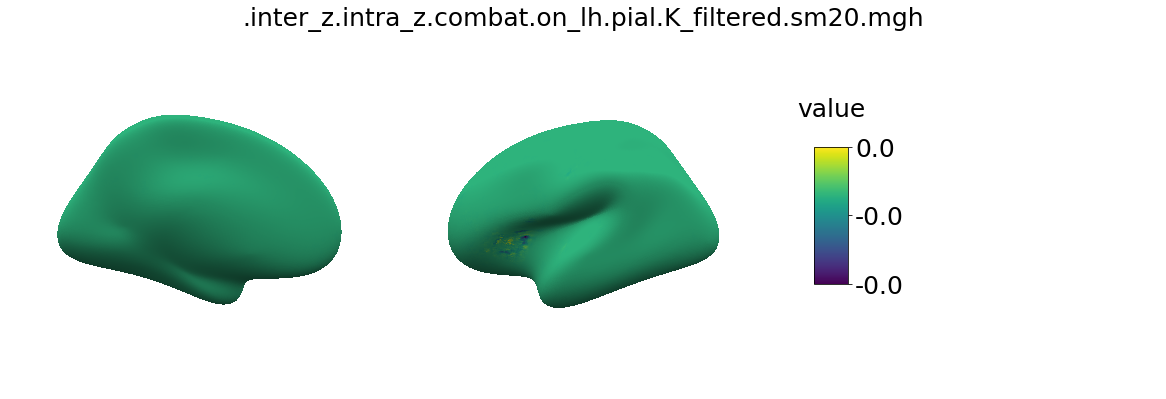

<Figure size 432x288 with 0 Axes>

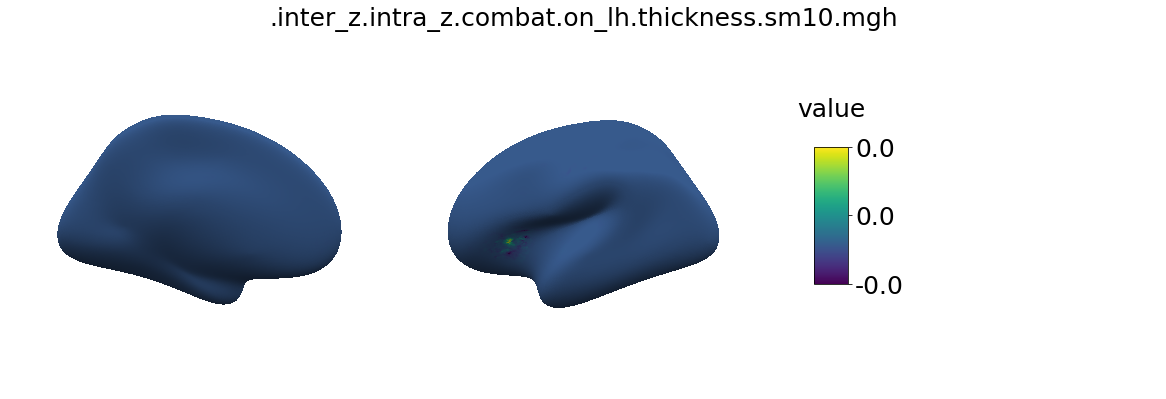

<Figure size 432x288 with 0 Axes>

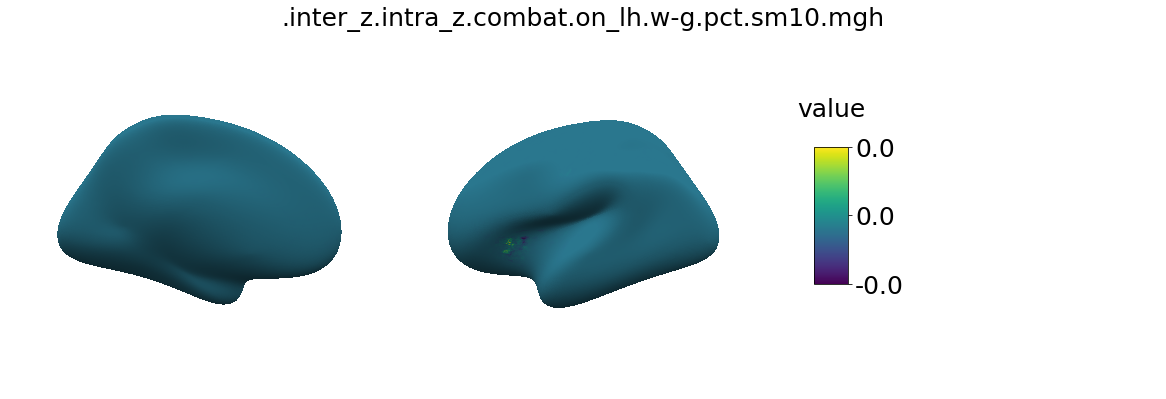

<Figure size 432x288 with 0 Axes>

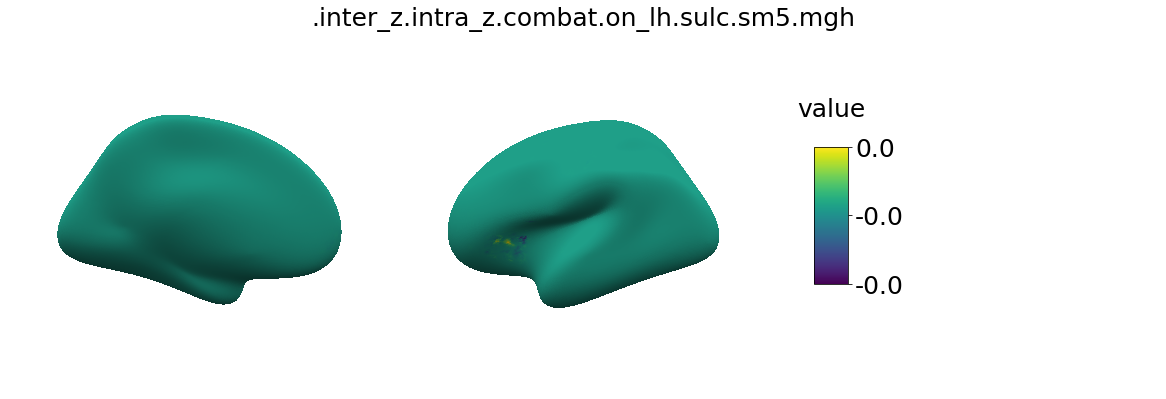

<Figure size 432x288 with 0 Axes>

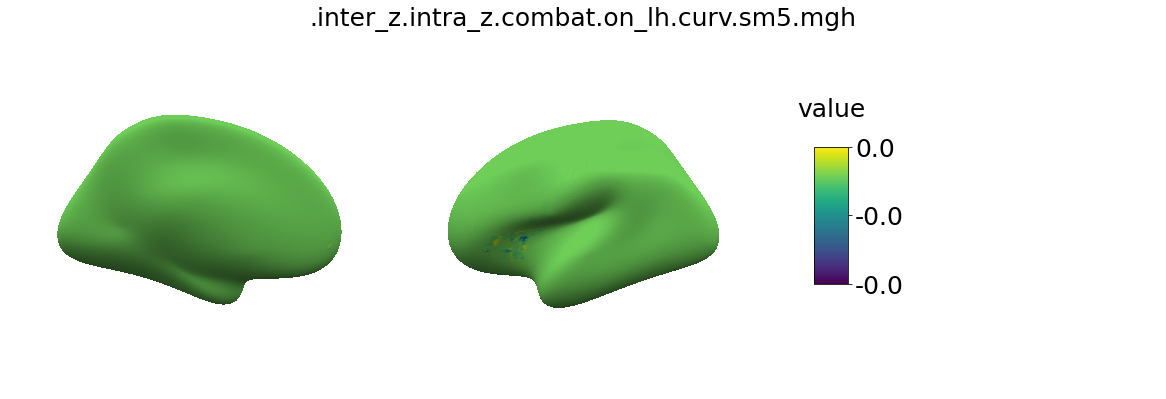

<Figure size 432x288 with 0 Axes>

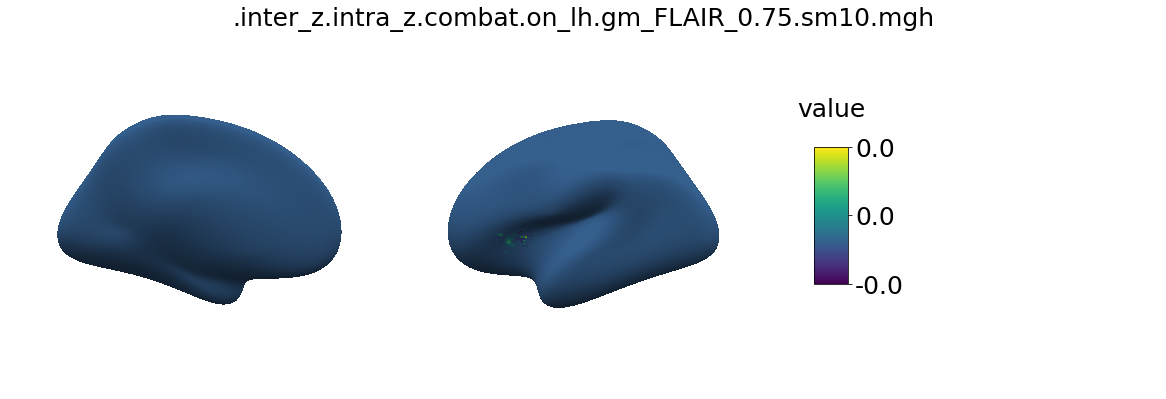

<Figure size 432x288 with 0 Axes>

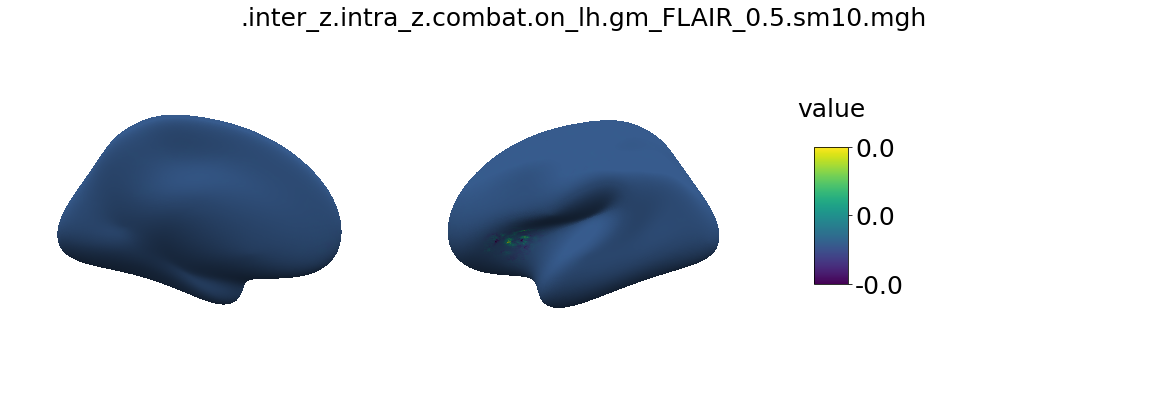

<Figure size 432x288 with 0 Axes>

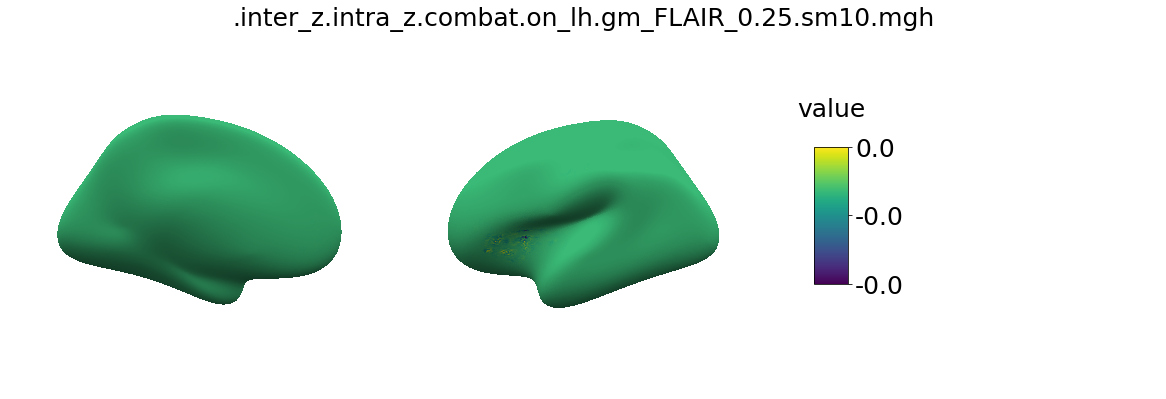

<Figure size 432x288 with 0 Axes>

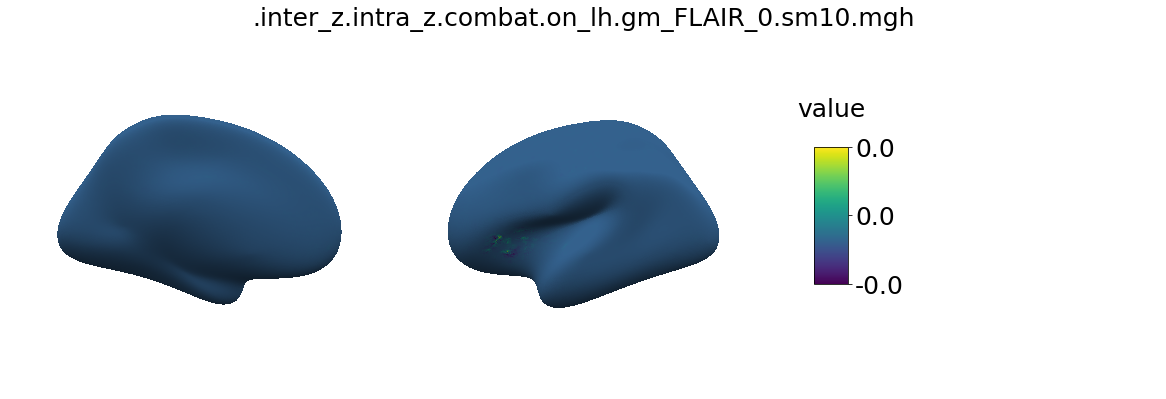

<Figure size 432x288 with 0 Axes>

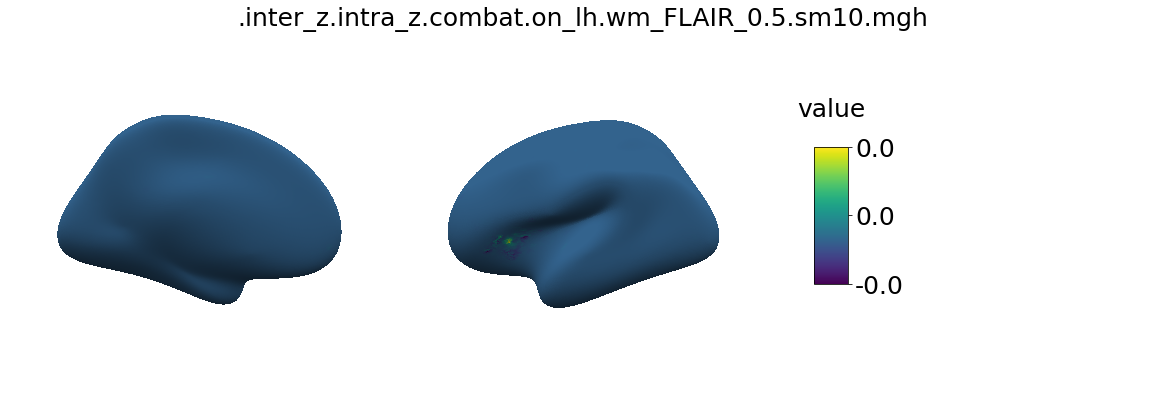

<Figure size 432x288 with 0 Axes>

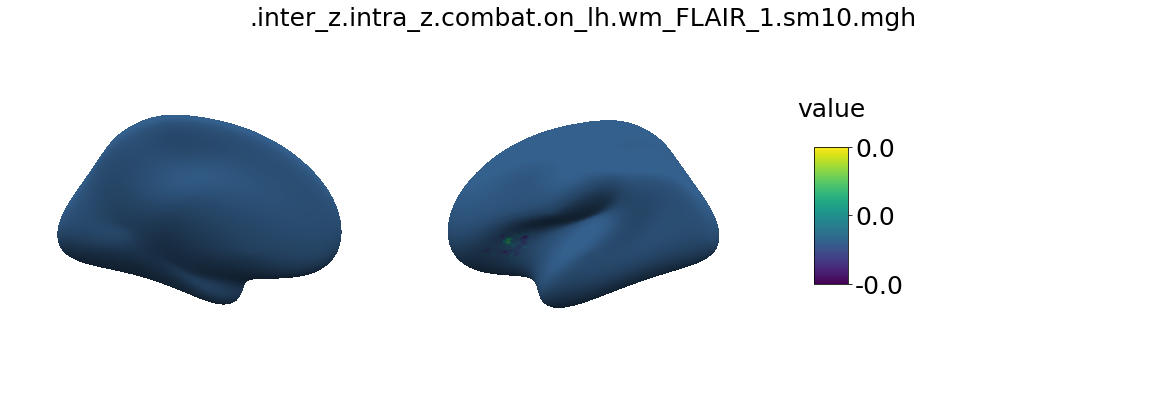

<Figure size 432x288 with 0 Axes>

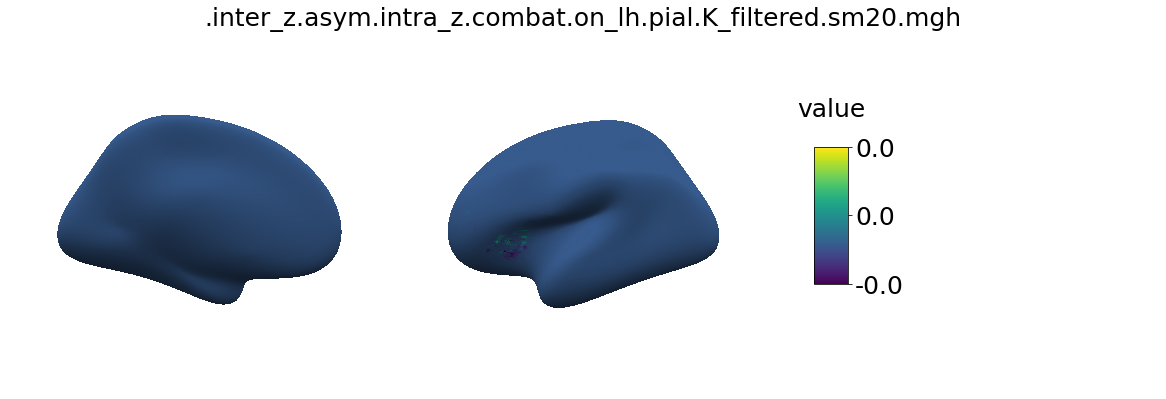

<Figure size 432x288 with 0 Axes>

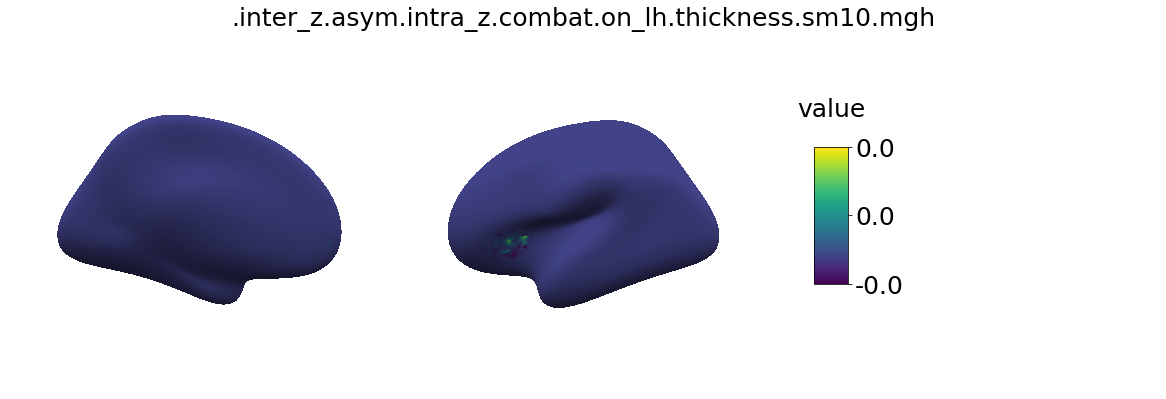

<Figure size 432x288 with 0 Axes>

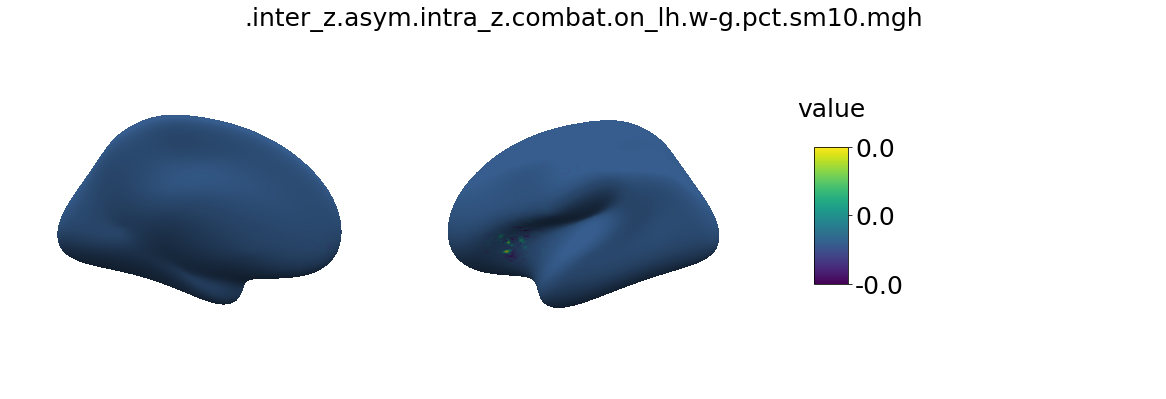

<Figure size 432x288 with 0 Axes>

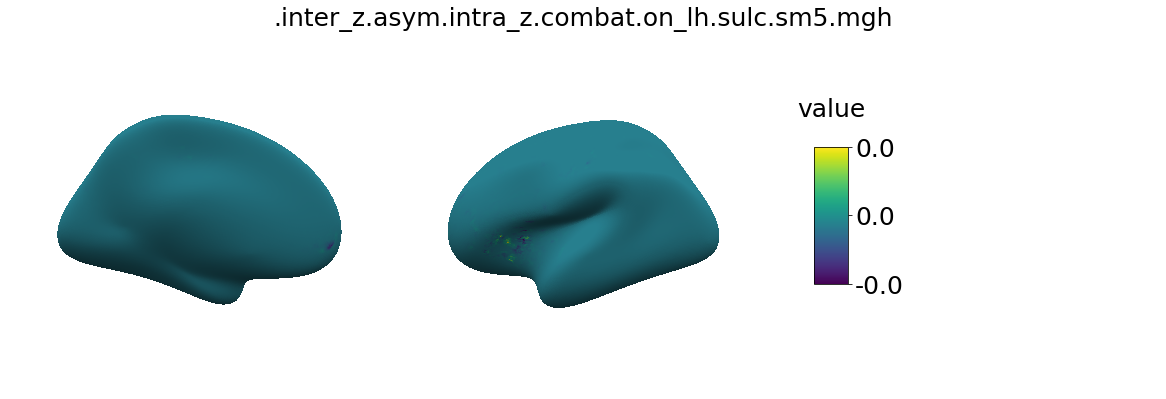

<Figure size 432x288 with 0 Axes>

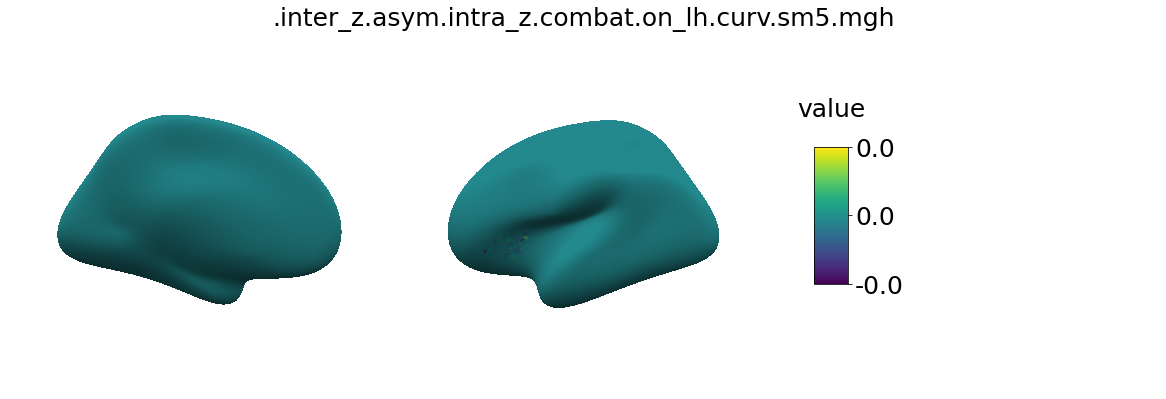

<Figure size 432x288 with 0 Axes>

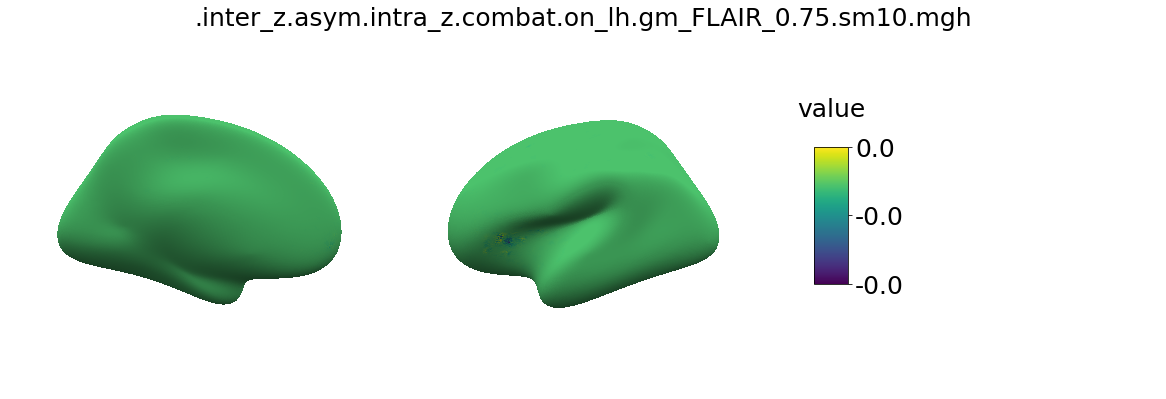

<Figure size 432x288 with 0 Axes>

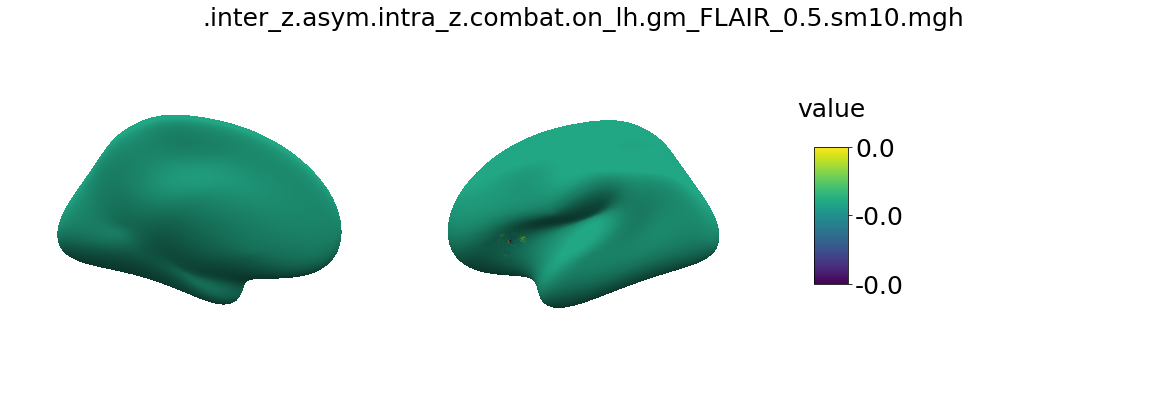

<Figure size 432x288 with 0 Axes>

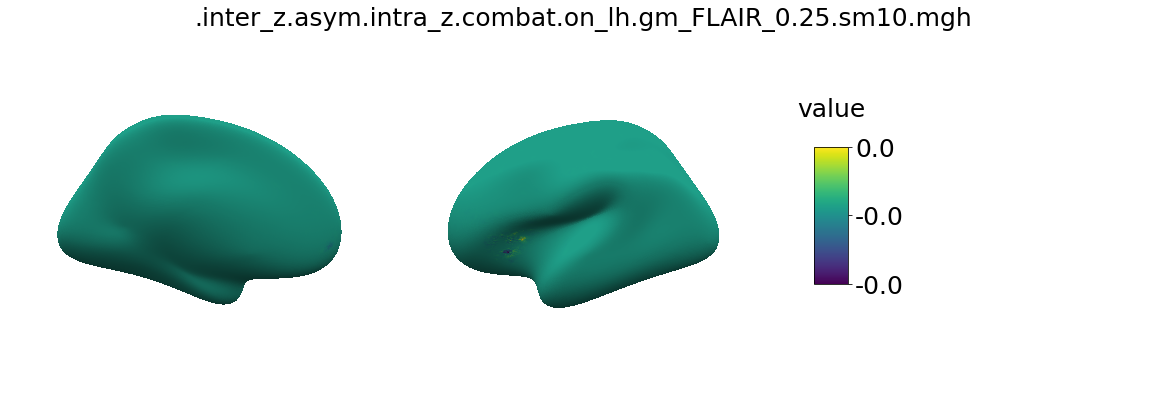

<Figure size 432x288 with 0 Axes>

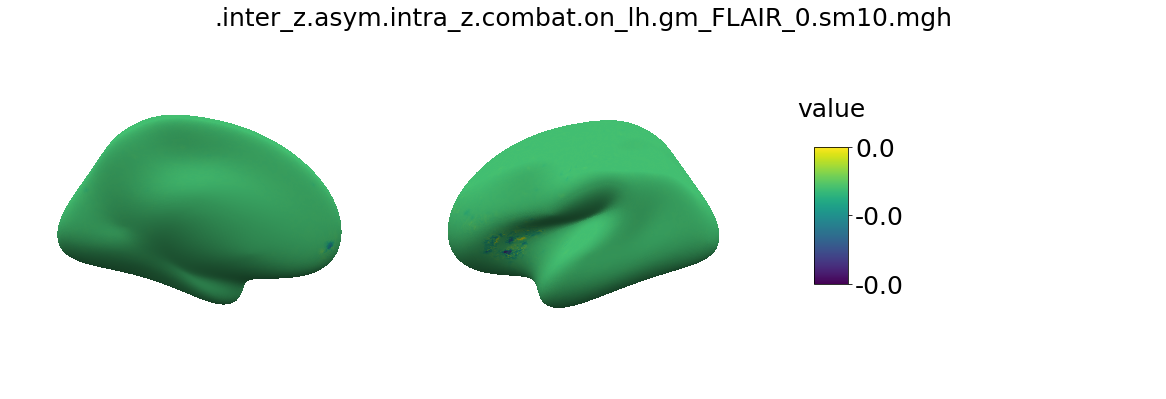

<Figure size 432x288 with 0 Axes>

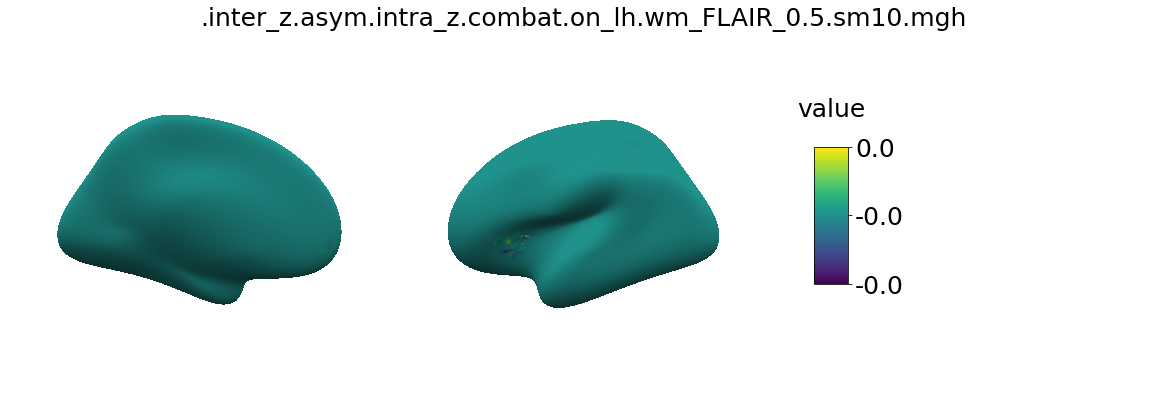

<Figure size 432x288 with 0 Axes>

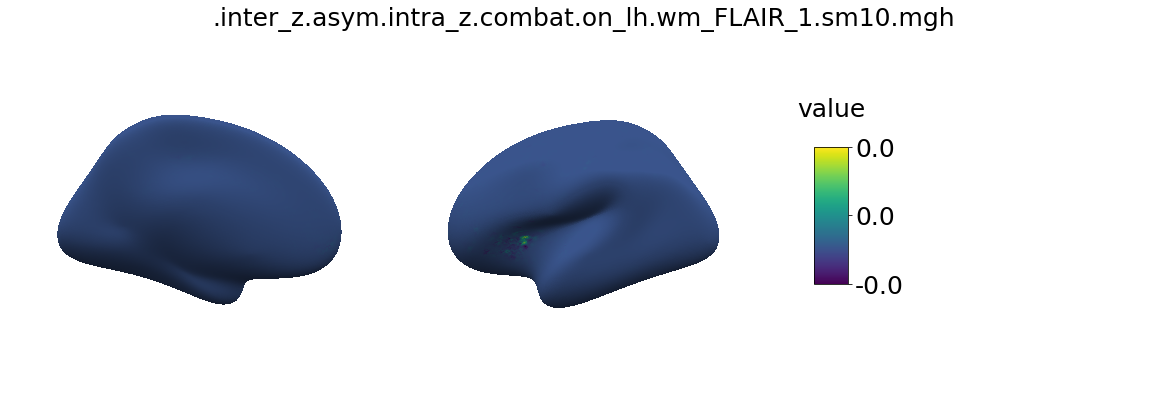

In [94]:
for i, feat in enumerate(features):
    plt.figure()
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],saliency[:,i], title=feat)